In [1]:
import json
import glob
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    cohen_kappa_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

sns.set(style="whitegrid")


In [4]:
DATA_DIR = Path("sca_llm_eval_data")

files = sorted(DATA_DIR.glob("record_*.json"))
print("Loaded files:", len(files))

records = []
for f in files:
    with open(f, "r", encoding="utf8") as fp:
        records.append(json.load(fp))

df = pd.DataFrame(records)

print("Total samples:", len(df))

Loaded files: 18
Total samples: 18


In [6]:
df = df[[
    "timestamp",
    "file_path",
    "language",
    "snippet_length",
    "trial_A",
    "trial_B",
    "verdict",
    "ground_truth"  # optional
]]

df.head()

,timestamp,file_path,language,snippet_length,trial_A,trial_B,verdict,ground_truth
0,2025-12-06T19:55:56.711Z,d:\llmproject\test.py,python,769,"{'verdict': 'safe', 'infringement_basis': 'ind...","{'verdict': 'low_risk', 'infringement_basis': ...",safe,"{'verdict': 'safe', 'infringement_basis': 'ind..."
1,2025-12-06T20:00:37.871Z,d:\llmproject\data\cpp\opencv\opencv-master\cm...,plaintext,3403,"{'verdict': 'medium_risk', 'infringement_basis...","{'verdict': 'low_risk', 'infringement_basis': ...",safe,"{'verdict': 'safe', 'infringement_basis': 'ind..."
2,2025-12-06T20:03:25.270Z,d:\llmproject\data\pypi\requests\requests-2.9....,python,767,"{'verdict': 'violation', 'infringement_basis':...","{'verdict': 'violation', 'infringement_basis':...",violation,"{'verdict': 'violation', 'infringement_basis':..."
3,2025-12-06T20:07:03.333Z,d:\llmproject\data\cpp\openssl\openssl-master\...,c,2624,"{'verdict': 'safe', 'infringement_basis': 'ind...","{'verdict': 'low_risk', 'infringement_basis': ...",safe,"{'verdict': 'safe', 'infringement_basis': 'ins..."
4,2025-12-06T20:09:39.436Z,d:\llmproject\data\cpp\openssl\openssl-master\...,c,45410,"{'verdict': 'safe', 'infringement_basis': 'ind...","{'verdict': 'safe', 'infringement_basis': 'cop...",safe,"{'verdict': 'safe', 'infringement_basis': 'cop..."


In [7]:
df["trialA_verdict"] = df["trial_A"].apply(lambda x: x.get("verdict") if isinstance(x, dict) else None)
df["trialB_verdict"] = df["trial_B"].apply(lambda x: x.get("verdict") if isinstance(x, dict) else None)
df["judge_verdict"]  = df["verdict"]

df["gt_verdict"] = df["ground_truth"].apply(
    lambda x: x.get("verdict") if isinstance(x, dict) else None
)


In [8]:
df_eval = df[df["gt_verdict"].notnull()].copy()
print("Samples with ground truth:", len(df_eval))


Samples with ground truth: 18


In [10]:
NORMALIZE_MAP = {
    "safe": "safe",
    "low_risk": "low_risk",
    "medium_risk": "high_risk",
    "high_risk": "high_risk",
    "violation": "violation"
}

def normalize_label(x):
    return NORMALIZE_MAP.get(x, None)

df_eval["gt_norm"]     = df_eval["gt_verdict"].apply(normalize_label)
df_eval["judge_norm"]  = df_eval["judge_verdict"].apply(normalize_label)
df_eval["trialA_norm"] = df_eval["trialA_verdict"].apply(normalize_label)
df_eval["trialB_norm"] = df_eval["trialB_verdict"].apply(normalize_label)


In [12]:
LABELS = ["safe", "low_risk", "high_risk", "violation"]

encoder = LabelEncoder()
encoder.fit(LABELS)

df_eval["gt_enc"]     = encoder.transform(df_eval["gt_norm"])
df_eval["judge_enc"]  = encoder.transform(df_eval["judge_norm"])
df_eval["trialA_enc"] = encoder.transform(df_eval["trialA_norm"])
df_eval["trialB_enc"] = encoder.transform(df_eval["trialB_norm"])


In [17]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.xticks(range(len(LABELS)), LABELS, rotation=30)
    plt.yticks(range(len(LABELS)), LABELS)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_cm(df_eval["gt_enc"], df_eval["judge_enc"],  "Judge vs Ground Truth")
plot_cm(df_eval["gt_enc"], df_eval["trialA_enc"], "Trial A vs Ground Truth")
plot_cm(df_eval["gt_enc"], df_eval["trialB_enc"], "Trial B vs Ground Truth")


NameError: name 'labels' is not defined

In [14]:
print("Cohen’s Kappa Scores")
print("-------------------")
print("Judge vs GT  :", cohen_kappa_score(df_eval["gt_enc"], df_eval["judge_enc"]))
print("Trial A vs GT:", cohen_kappa_score(df_eval["gt_enc"], df_eval["trialA_enc"]))
print("Trial B vs GT:", cohen_kappa_score(df_eval["gt_enc"], df_eval["trialB_enc"]))


Cohen’s Kappa Scores
-------------------
Judge vs GT  : 0.6883116883116882
Trial A vs GT: 0.45922746781115875
Trial B vs GT: 0.17557251908396954


In [15]:
print("Judge Classification Report")
print(classification_report(
    df_eval["gt_enc"],
    df_eval["judge_enc"],
    target_names=LABELS
))


Judge Classification Report
              precision    recall  f1-score   support

        safe       0.75      0.60      0.67         5
    low_risk       1.00      0.50      0.67         2
   high_risk       1.00      1.00      1.00         6
   violation       0.57      0.80      0.67         5

    accuracy                           0.78        18
   macro avg       0.83      0.73      0.75        18
weighted avg       0.81      0.78      0.78        18



In [16]:
enc = LabelEncoder()

df_eval["language_enc"] = enc.fit_transform(df_eval["language"])
df_eval["path_enc"]     = enc.fit_transform(df_eval["path_category"])

verdict_order = ["safe", "low_risk", "high_risk", "violation"]
verdict_enc = {v: i for i, v in enumerate(verdict_order)}

df_eval["judge_enc"]  = df_eval["judge_norm"].map(verdict_enc)
df_eval["trialA_enc"] = df_eval["trialA_norm"].map(verdict_enc)
df_eval["trialB_enc"] = df_eval["trialB_norm"].map(verdict_enc)


KeyError: 'path_category'

In [11]:
df_eval = df_eval.dropna(subset=[
    "gt_norm",
    "judge_norm",
    "trialA_norm",
    "trialB_norm"
])


In [8]:
df["has_gt"] = df["ground_truth"].apply(lambda x: x is not None)
print("Ground truth samples:", df["has_gt"].sum(), "/", len(df))
df_gt = df[df["has_gt"] == True].copy()
df_gt.head()

Ground truth samples: 18 / 18


,timestamp,file_path,language,code_hash,snippet,snippet_length,trial_A,trial_B,verdict,infringement_basis,license_risk,reasoning,model_comparison,error_analysis,raw_output,ground_truth,has_gt
0,2025-12-06T19:55:56.711Z,d:\llmproject\test.py,python,31bab9c872bf9921b90d4332565e8fcfa768aeba77b776...,"\r\n\r\n# Line 1\r\nprint(""Starting Python tes...",769,"{'verdict': 'safe', 'infringement_basis': 'ind...","{'verdict': 'low_risk', 'infringement_basis': ...",safe,independent,none,Both models correctly assess this as a low-ris...,"{'model_a_score': 10, 'model_b_score': 10, 'be...","{'model_a_issues': [], 'model_b_issues': []}","{'trial_A': {'verdict': 'safe', 'infringement_...","{'verdict': 'safe', 'infringement_basis': 'ind...",True
1,2025-12-06T20:00:37.871Z,d:\llmproject\data\cpp\opencv\opencv-master\cm...,plaintext,4e4436da157eb88f3a27a3f0fc093a97a27ee4d46d129d...,"include(""${CONFIG_FILE}"")\nset(prefix ""COPYFIL...",3403,"{'verdict': 'medium_risk', 'infringement_basis...","{'verdict': 'low_risk', 'infringement_basis': ...",safe,independent,none,Both models arrive at the same conclusion: the...,"{'model_a_score': 10, 'model_b_score': 10, 'be...","{'model_a_issues': [], 'model_b_issues': []}","{'trial_A': {'verdict': 'medium_risk', 'infrin...","{'verdict': 'safe', 'infringement_basis': 'ind...",True
2,2025-12-06T20:03:25.270Z,d:\llmproject\data\pypi\requests\requests-2.9....,python,8d2766663079a1127ac6628cdd5b6a91892af28153c31e...,"# -*- coding: utf-8 -*-\n\n""""""\nrequests.hooks...",767,"{'verdict': 'violation', 'infringement_basis':...","{'verdict': 'violation', 'infringement_basis':...",violation,copied,attribution_required,Both Model A and Model B correctly identify a ...,"{'model_a_score': 10, 'model_b_score': 10, 'be...","{'model_a_issues': [], 'model_b_issues': []}","{'trial_A': {'verdict': 'violation', 'infringe...","{'verdict': 'violation', 'infringement_basis':...",True
3,2025-12-06T20:07:03.333Z,d:\llmproject\data\cpp\openssl\openssl-master\...,c,61332bd16ea2fc016019f8092d03a1db58c68a1a8a3041...,/*\n * Copyright 2016-2025 The OpenSSL Project...,2624,"{'verdict': 'safe', 'infringement_basis': 'ind...","{'verdict': 'low_risk', 'infringement_basis': ...",safe,inspired,attribution_required,Model A's analysis is more accurate and ground...,"{'model_a_score': 10, 'model_b_score': 7, 'bet...","{'model_a_issues': [], 'model_b_issues': ['Hal...","{'trial_A': {'verdict': 'safe', 'infringement_...","{'verdict': 'safe', 'infringement_basis': 'ins...",True
4,2025-12-06T20:09:39.436Z,d:\llmproject\data\cpp\openssl\openssl-master\...,c,3271017cf75bb29fd06bb5d48c6e8e7a3c20b240115b32...,/*\n * Copyright 2016-2025 The OpenSSL Project...,45410,"{'verdict': 'safe', 'infringement_basis': 'ind...","{'verdict': 'safe', 'infringement_basis': 'cop...",safe,inspired,attribution_required,Model A and Model B both correctly identify th...,"{'model_a_score': 10, 'model_b_score': 10, 'be...","{'model_a_issues': [], 'model_b_issues': []}","{'trial_A': {'verdict': 'safe', 'infringement_...","{'verdict': 'safe', 'infringement_basis': 'cop...",True


In [9]:
df_gt["snippet_length"] = pd.to_numeric(df_gt["snippet_length"], errors="coerce")
df_gt = df_gt.dropna(subset=["snippet_length"])



In [10]:
df_gt["gt_verdict"] = df_gt["ground_truth"].apply(lambda x: x.get("verdict"))
df_gt["gt_basis"] = df_gt["ground_truth"].apply(lambda x: x.get("infringement_basis"))
df_gt["gt_license"] = df_gt["ground_truth"].apply(lambda x: x.get("license_risk"))
df_gt["gt_confidence"] = df_gt["ground_truth"].apply(lambda x: x.get("confidence"))

In [11]:
df_gt["trialA_verdict"] = df_gt["trial_A"].apply(lambda x: x.get("verdict") if x else None)
df_gt["trialB_verdict"] = df_gt["trial_B"].apply(lambda x: x.get("verdict") if x else None)
df_gt["judge_verdict"] = df_gt.apply(lambda x: x.get("verdict"), axis=1)

In [12]:
df_gt["trialA_basis"] = df_gt["trial_A"].apply(lambda x: x.get("infringement_basis") if x else None)
df_gt["trialB_basis"] = df_gt["trial_B"].apply(lambda x: x.get("infringement_basis") if x else None)
df_gt["judge_basis"] = df_gt.apply(lambda x: x.get("infringement_basis"), axis=1)



In [13]:
df_gt["trialA_license"] = df_gt["trial_A"].apply(lambda x: x.get("license_risk") if x else None)
df_gt["trialB_license"] = df_gt["trial_B"].apply(lambda x: x.get("license_risk") if x else None)
df_gt["judge_license"] = df_gt.apply(lambda x: x.get("license_risk"), axis=1)


In [14]:
def compute_metrics(true, pred, label="Model"):
    print(f"\n=== {label} ===")
    print("Accuracy:", accuracy_score(true, pred))
    print("Precision (macro):", precision_score(true, pred, average="macro", zero_division=0))
    print("Recall (macro):", recall_score(true, pred, average="macro", zero_division=0))
    print("F1 Score (macro):", f1_score(true, pred, average="macro", zero_division=0))
    print("\nClassification Report:\n", classification_report(true, pred, zero_division=0))


In [15]:
#Evaluate Verdict Classification

print("Ground truth count:", len(df_gt))

y_true = df_gt["gt_verdict"]

compute_metrics(y_true, df_gt["trialA_verdict"], label="Trial A Verdict")
compute_metrics(y_true, df_gt["trialB_verdict"], label="Trial B Verdict")
compute_metrics(y_true, df_gt["judge_verdict"], label="Judge Verdict (Final)")


Ground truth count: 18

=== Trial A Verdict ===
Accuracy: 0.6111111111111112
Precision (macro): 0.575
Recall (macro): 0.48
F1 Score (macro): 0.49606837606837606

Classification Report:
               precision    recall  f1-score   support

   high_risk       0.50      0.40      0.44         5
    low_risk       1.00      0.50      0.67         2
 medium_risk       0.00      0.00      0.00         0
        safe       0.75      0.50      0.60         6
   violation       0.62      1.00      0.77         5

    accuracy                           0.61        18
   macro avg       0.57      0.48      0.50        18
weighted avg       0.67      0.61      0.61        18


=== Trial B Verdict ===
Accuracy: 0.3333333333333333
Precision (macro): 0.4666666666666666
Recall (macro): 0.4333333333333333
F1 Score (macro): 0.3333333333333333

Classification Report:
               precision    recall  f1-score   support

   high_risk       0.33      0.20      0.25         5
    low_risk       0.20    

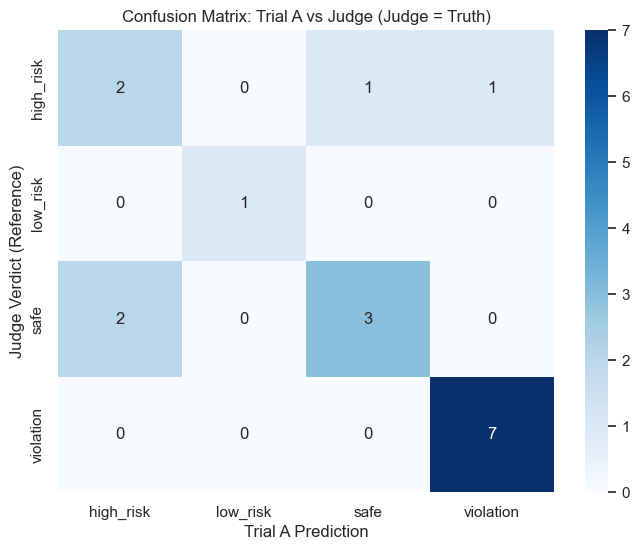

In [16]:
#Confusion Matrix — Trial A vs Judge

labels = sorted(df_gt["judge_verdict"].unique())

cm_AJ = confusion_matrix(df_gt["judge_verdict"], df_gt["trialA_verdict"], labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_AJ, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix: Trial A vs Judge (Judge = Truth)")
plt.xlabel("Trial A Prediction")
plt.ylabel("Judge Verdict (Reference)")
plt.show()



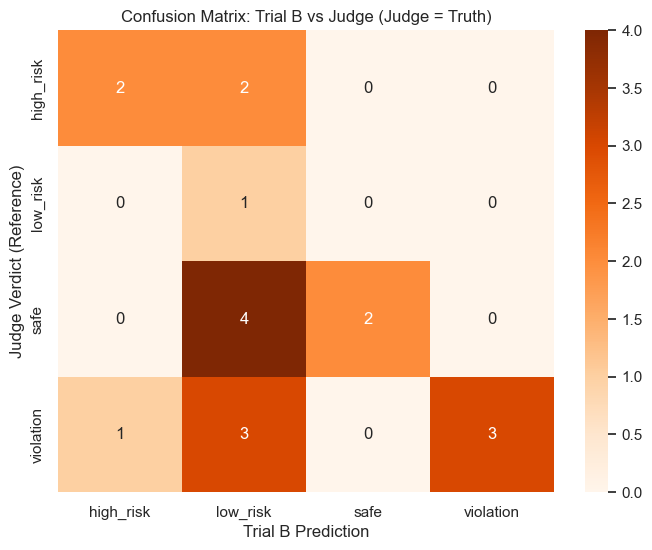

In [17]:
#Confusion Matrix — Trial B vs Judge

labels = sorted(df_gt["judge_verdict"].unique())

cm_BJ = confusion_matrix(df_gt["judge_verdict"], df_gt["trialB_verdict"], labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_BJ, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels, cmap="Oranges")
plt.title("Confusion Matrix: Trial B vs Judge (Judge = Truth)")
plt.xlabel("Trial B Prediction")
plt.ylabel("Judge Verdict (Reference)")
plt.show()


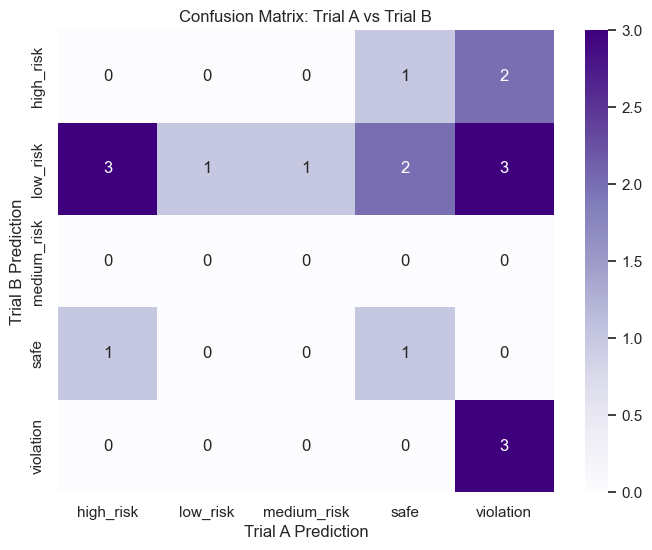

In [18]:
#Confusion Matrix — Trial A vs Trial B

labels = sorted(set(df_gt["trialA_verdict"].unique()) | set(df_gt["trialB_verdict"].unique()))

cm_AB = confusion_matrix(df_gt["trialB_verdict"], df_gt["trialA_verdict"], labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_AB, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels, cmap="Purples")
plt.title("Confusion Matrix: Trial A vs Trial B")
plt.xlabel("Trial A Prediction")
plt.ylabel("Trial B Prediction")
plt.show()


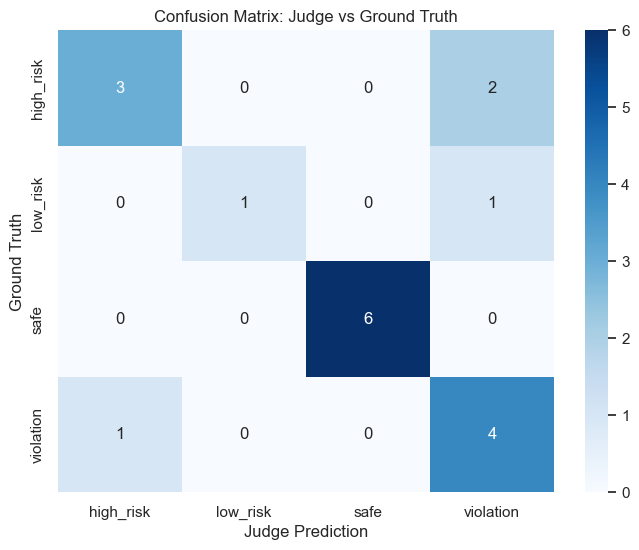

In [19]:
#Verdict Confusion Matrix

labels = sorted(df_gt["gt_verdict"].unique())

cm = confusion_matrix(df_gt["gt_verdict"], df_gt["judge_verdict"], labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix: Judge vs Ground Truth")
plt.xlabel("Judge Prediction")
plt.ylabel("Ground Truth")
plt.show()


In [20]:
#Arbitration Success Rate
judge_correct = df_gt[df_gt["judge_verdict"] == df_gt["gt_verdict"]]

trialA_wrong = df_gt[df_gt["trialA_verdict"] != df_gt["gt_verdict"]]
trialB_wrong = df_gt[df_gt["trialB_verdict"] != df_gt["gt_verdict"]]

arb_success_A = judge_correct[judge_correct["trialA_verdict"] != judge_correct["gt_verdict"]]
arb_success_B = judge_correct[judge_correct["trialB_verdict"] != judge_correct["gt_verdict"]]

print("Judge arbitration success against Trial A:", len(arb_success_A))
print("Judge arbitration success against Trial B:", len(arb_success_B))

print("\nJudge arbitration success rate:",
      (len(arb_success_A) + len(arb_success_B)) / len(df_gt) * 100, "%")


Judge arbitration success against Trial A: 4
Judge arbitration success against Trial B: 9

Judge arbitration success rate: 72.22222222222221 %


In [21]:
#Cohen’s Kappa (Agreement Metrics)
print("Trial A vs Judge:", cohen_kappa_score(df_gt["trialA_verdict"], df_gt["judge_verdict"]))
print("Trial B vs Judge:", cohen_kappa_score(df_gt["trialB_verdict"], df_gt["judge_verdict"]))
print("Trial A vs Trial B:", cohen_kappa_score(df_gt["trialA_verdict"], df_gt["trialB_verdict"]))


#1.0 → perfect agreement

#0.6–0.8 → strong

#0.4–0.6 → moderate

#0.2–0.4 → weak

#< 0.2 → poor


Trial A vs Judge: 0.6035242290748899
Trial B vs Judge: 0.33085501858736055
Trial A vs Trial B: 0.1333333333333333


In [22]:
def extract_gt_verdict(x):
    if isinstance(x, dict):
        return x.get("verdict", "unknown")
    return "unknown"
df_gt["gt_verdict"] = df_gt["ground_truth"].apply(extract_gt_verdict)
print(df_gt["gt_verdict"].unique())
all_classes = ["safe", "low_risk", "high_risk", "violation"]
df_gt["judge_norm"] = df_gt["judge_verdict"].apply(
    lambda x: x if x in all_classes else "unknown"
)

df_gt["gt_norm"] = df_gt["gt_verdict"].apply(
    lambda x: x if x in all_classes else "unknown"
)
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
enc.fit(all_classes + ["unknown"])   # ensures consistent mapping

df_gt["gt_enc"] = enc.transform(df_gt["gt_norm"])
df_gt["judge_enc"] = enc.transform(df_gt["judge_norm"])
print("Ground Truth Encoded:", df_gt["gt_enc"].unique())
print("Judge Encoded:", df_gt["judge_enc"].unique())
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(df_gt["gt_enc"], df_gt["judge_enc"])
print("Judge vs Ground Truth Kappa:", kappa)


['safe' 'violation' 'high_risk' 'low_risk']
Ground Truth Encoded: [2 4 0 1]
Judge Encoded: [2 4 0 1]
Judge vs Ground Truth Kappa: 0.6883116883116882


In [23]:
#License Risk Accuracy
compute_metrics(df_gt["gt_license"], df_gt["trialA_license"], label="Trial A License")
compute_metrics(df_gt["gt_license"], df_gt["trialB_license"], label="Trial B License")
compute_metrics(df_gt["gt_license"], df_gt["judge_license"], label="Judge License")



=== Trial A License ===
Accuracy: 0.6111111111111112
Precision (macro): 0.5592592592592592
Recall (macro): 0.6091269841269841
F1 Score (macro): 0.5623885918003565

Classification Report:
                            precision    recall  f1-score   support

     attribution_required       0.78      0.88      0.82         8
                     none       0.50      0.29      0.36         7
strong_copyleft_violation       0.40      0.67      0.50         3

                 accuracy                           0.61        18
                macro avg       0.56      0.61      0.56        18
             weighted avg       0.61      0.61      0.59        18


=== Trial B License ===
Accuracy: 0.7222222222222222
Precision (macro): 0.797979797979798
Recall (macro): 0.6349206349206349
F1 Score (macro): 0.6524966261808367

Classification Report:
                            precision    recall  f1-score   support

     attribution_required       0.73      1.00      0.84         8
                

In [24]:
#Infringement Basis Accuracy
compute_metrics(df_gt["gt_basis"], df_gt["trialA_basis"], label="Trial A Basis")
compute_metrics(df_gt["gt_basis"], df_gt["trialB_basis"], label="Trial B Basis")
compute_metrics(df_gt["gt_basis"], df_gt["judge_basis"], label="Judge Basis")



=== Trial A Basis ===
Accuracy: 0.6666666666666666
Precision (macro): 0.6805555555555556
Recall (macro): 0.5984848484848485
F1 Score (macro): 0.6027777777777779

Classification Report:
               precision    recall  f1-score   support

      copied       0.89      0.73      0.80        11
  derivative       1.00      0.50      0.67         2
 independent       0.33      0.67      0.44         3
    inspired       0.50      0.50      0.50         2

    accuracy                           0.67        18
   macro avg       0.68      0.60      0.60        18
weighted avg       0.77      0.67      0.69        18


=== Trial B Basis ===
Accuracy: 0.6666666666666666
Precision (macro): 0.49722222222222223
Recall (macro): 0.5568181818181819
F1 Score (macro): 0.5125

Classification Report:
               precision    recall  f1-score   support

      copied       0.89      0.73      0.80        11
  derivative       0.00      0.00      0.00         2
 independent       0.60      1.00      

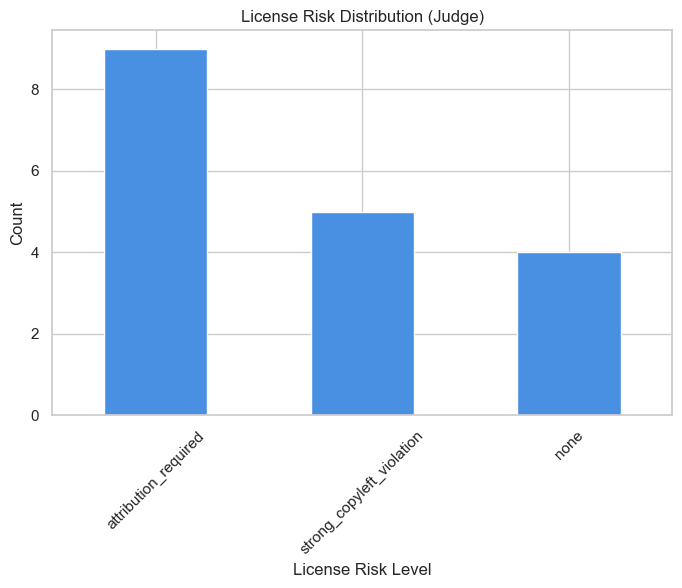

In [25]:
#License Risk Distribution (Judge Output)

plt.figure(figsize=(8,5))
df_gt["judge_license"].value_counts().plot(kind="bar", color="#4A90E2")
plt.title("License Risk Distribution (Judge)")
plt.xlabel("License Risk Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


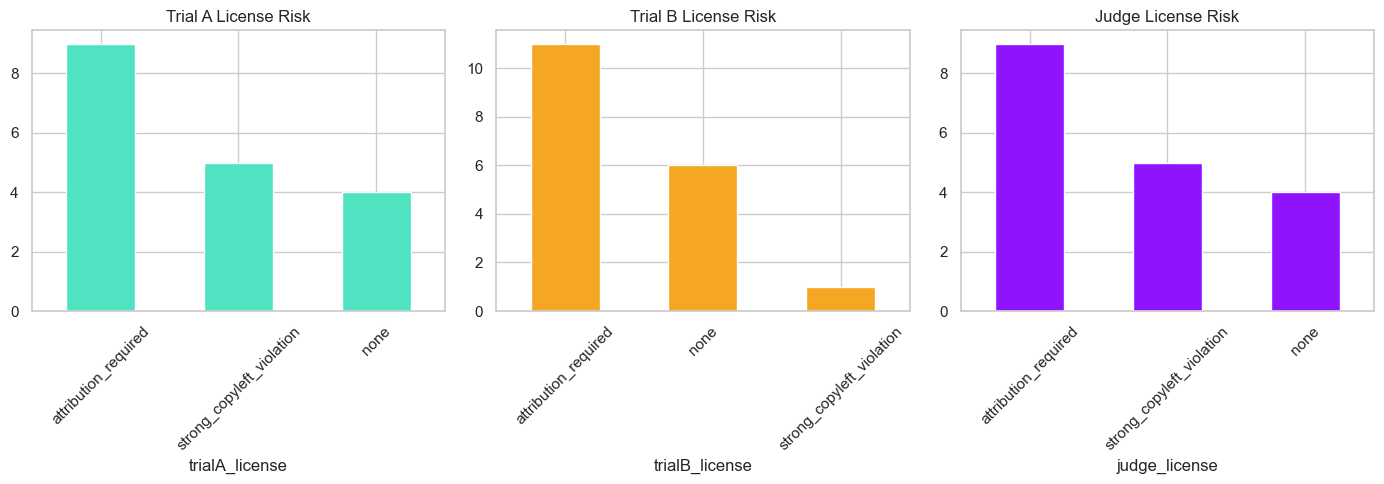

In [26]:
#License Risk Distribution (Trial A and Trial B)
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
df_gt["trialA_license"].value_counts().plot(kind="bar", color="#50E3C2")
plt.title("Trial A License Risk")
plt.xticks(rotation=45)

plt.subplot(1,3,2)
df_gt["trialB_license"].value_counts().plot(kind="bar", color="#F5A623")
plt.title("Trial B License Risk")
plt.xticks(rotation=45)

plt.subplot(1,3,3)
df_gt["judge_license"].value_counts().plot(kind="bar", color="#9013FE")
plt.title("Judge License Risk")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


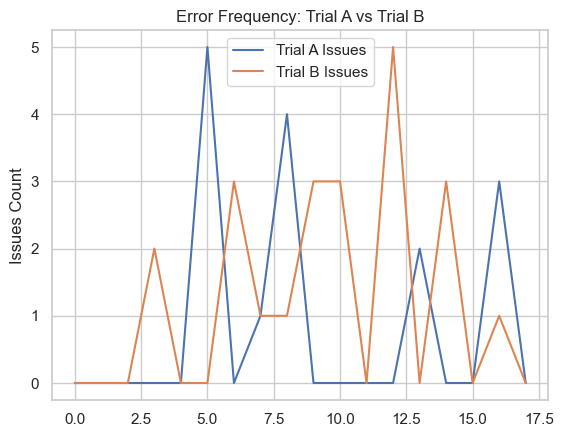

In [27]:
#Error Taxonomy Summary
error_A = df_gt["error_analysis"].apply(lambda x: len(x["model_a_issues"]) if x else 0)
error_B = df_gt["error_analysis"].apply(lambda x: len(x["model_b_issues"]) if x else 0)

plt.plot(error_A.values, label="Trial A Issues")
plt.plot(error_B.values, label="Trial B Issues")
plt.legend()
plt.title("Error Frequency: Trial A vs Trial B")
plt.ylabel("Issues Count")
plt.show()


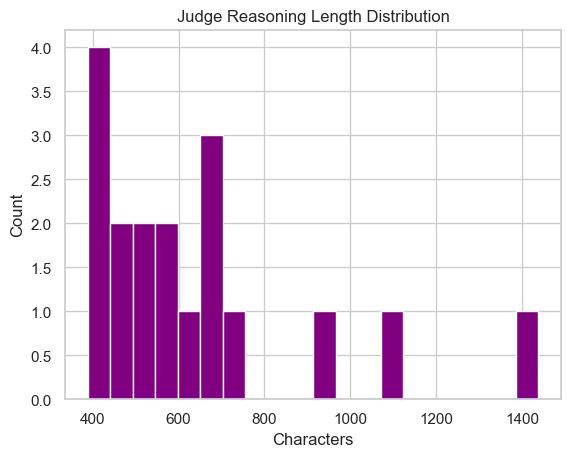

In [28]:
#Judge Reasoning Length Analysis
df_gt["reasoning_len"] = df_gt["reasoning"].apply(lambda x: len(x) if isinstance(x, str) else 0)

plt.hist(df_gt["reasoning_len"], bins=20, color="purple")
plt.title("Judge Reasoning Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()


In [29]:
df_gt["duplicate_count"] = df_gt.groupby("code_hash")["code_hash"].transform("count")
df_gt[["code_hash", "duplicate_count"]].head()


,code_hash,duplicate_count
0,31bab9c872bf9921b90d4332565e8fcfa768aeba77b776...,1
1,4e4436da157eb88f3a27a3f0fc093a97a27ee4d46d129d...,1
2,8d2766663079a1127ac6628cdd5b6a91892af28153c31e...,5
3,61332bd16ea2fc016019f8092d03a1db58c68a1a8a3041...,1
4,3271017cf75bb29fd06bb5d48c6e8e7a3c20b240115b32...,1


In [30]:
def categorize_path(path):
    p = path.lower()
    if "requests" in p:
        return "requests_pkg"
    if "curl" in p:
        return "curl_pkg"
    if "flask" in p:
        return "flask_pkg"
    return "other"

df_gt["path_category"] = df_gt["file_path"].apply(categorize_path)

df_gt["path_category"].value_counts()


path_category
other           13
requests_pkg     5
Name: count, dtype: int64

In [31]:
pd.crosstab(df_gt["path_category"], df_gt["judge_verdict"])



judge_verdict,high_risk,low_risk,safe,violation
path_category,,,,
other,3,1,6,3
requests_pkg,1,0,0,4


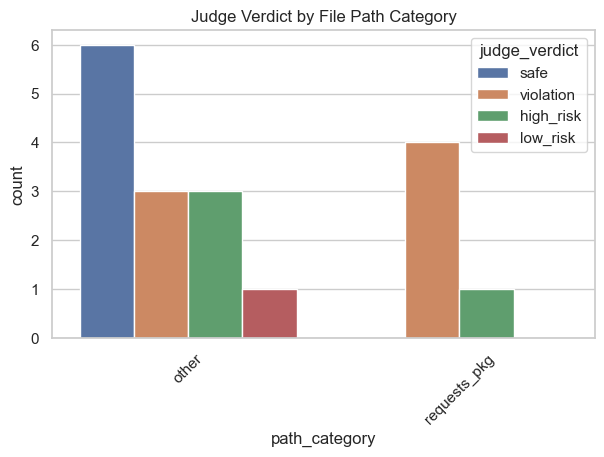

In [32]:
plt.figure(figsize=(7,4))
sns.countplot(data=df_gt, x="path_category", hue="judge_verdict")
plt.title("Judge Verdict by File Path Category")
plt.xticks(rotation=45)
plt.show()

In [33]:
pd.crosstab(df_gt["language"], df_gt["judge_verdict"])


judge_verdict,high_risk,low_risk,safe,violation
language,,,,
c,1,0,4,0
cpp,2,0,0,0
plaintext,0,0,1,0
python,1,1,1,7


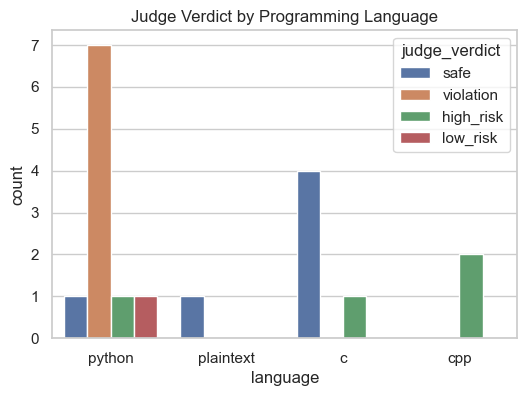

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_gt, x="language", hue="judge_verdict")
plt.title("Judge Verdict by Programming Language")
plt.show()


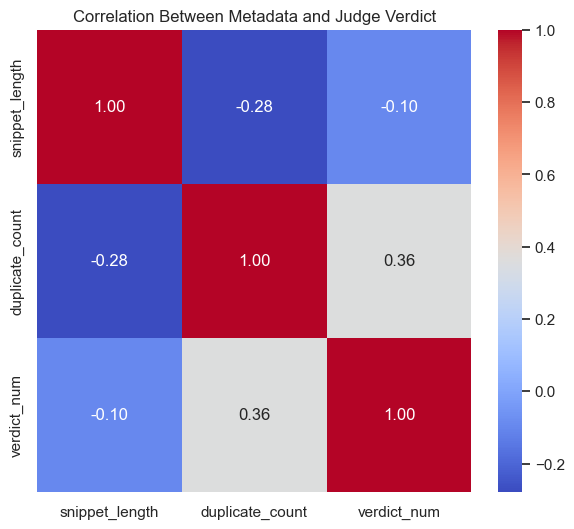

In [36]:
# Encode verdicts numerically
df_gt["verdict_num"] = df_gt["judge_verdict"].astype("category").cat.codes

corr_features = df_gt[[
    "snippet_length",
    "duplicate_count",
    "verdict_num"
]]

plt.figure(figsize=(7,6))
sns.heatmap(corr_features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Metadata and Judge Verdict")
plt.show()


In [37]:
df_gt[["file_path", "snippet_length"]]


,file_path,snippet_length
0,d:\llmproject\test.py,769
1,d:\llmproject\data\cpp\opencv\opencv-master\cm...,3403
2,d:\llmproject\data\pypi\requests\requests-2.9....,767
3,d:\llmproject\data\cpp\openssl\openssl-master\...,2624
4,d:\llmproject\data\cpp\openssl\openssl-master\...,45410
5,d:\llmproject\data\high_risk\glibc\glibc-maste...,3556
6,d:\llmproject\data\high_risk\glibc\glibc-maste...,2660
7,d:\llmproject\data\high_risk\glibc\glibc-maste...,3556
8,d:\llmproject\data\cpp\opencv\opencv-master\sa...,7205
9,d:\llmproject\data\cpp\opencv\opencv-master\sa...,6760


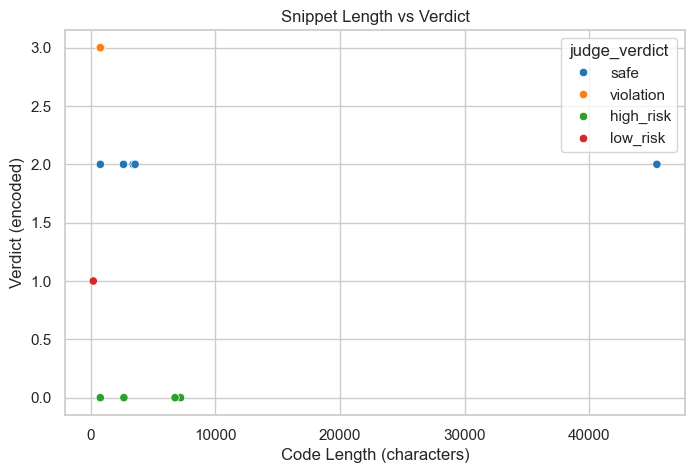

In [38]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_gt, x="snippet_length", y="verdict_num", hue="judge_verdict", palette="tab10")
plt.title("Snippet Length vs Verdict")
plt.xlabel("Code Length (characters)")
plt.ylabel("Verdict (encoded)")
plt.show()


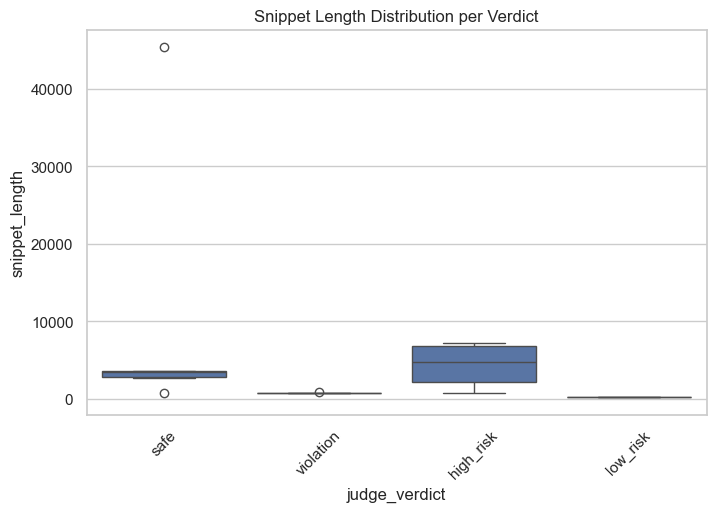

In [39]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_gt, x="judge_verdict", y="snippet_length")
plt.title("Snippet Length Distribution per Verdict")
plt.xticks(rotation=45)
plt.show()


In [41]:
def categorize_path(path):
    p = str(path).lower()
    if "requests" in p:
        return "requests_pkg"
    if "curl" in p:
        return "curl_pkg"
    if "flask" in p:
        return "flask_pkg"
    return "other"

df_gt["path_category"] = df_gt["file_path"].apply(categorize_path)
df_gt["path_category"].value_counts()


path_category
other           13
requests_pkg     5
Name: count, dtype: int64

In [42]:
df_gt["path_cat_num"] = df_gt["path_category"].astype("category").cat.codes
df_gt[["path_category", "path_cat_num"]].head()


,path_category,path_cat_num
0,other,0
1,other,0
2,requests_pkg,1
3,other,0
4,other,0


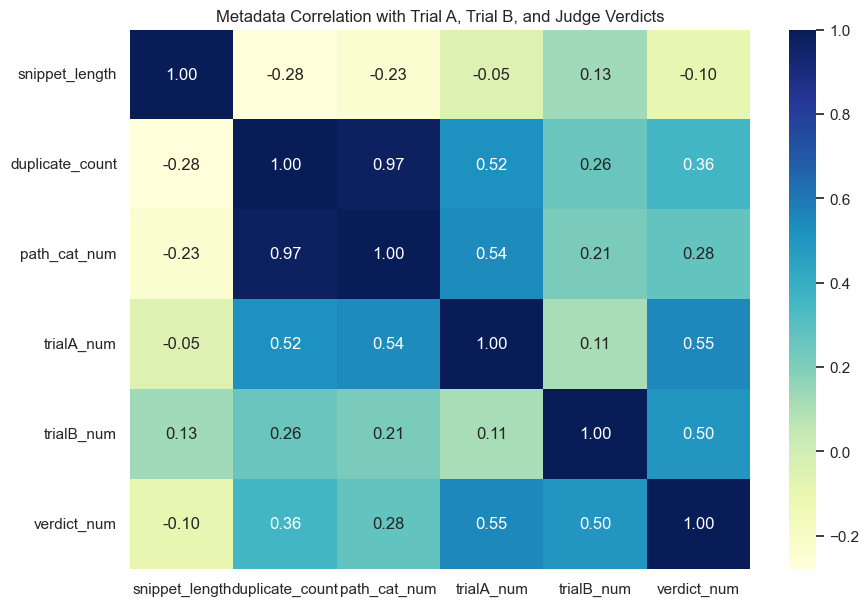

In [43]:
df_gt["trialA_num"] = df_gt["trialA_verdict"].astype("category").cat.codes
df_gt["trialB_num"] = df_gt["trialB_verdict"].astype("category").cat.codes

meta_corr = df_gt[[
    "snippet_length",
    "duplicate_count",
    "path_cat_num",
    "trialA_num",
    "trialB_num",
    "verdict_num"
]].corr()

plt.figure(figsize=(10,7))
sns.heatmap(meta_corr, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Metadata Correlation with Trial A, Trial B, and Judge Verdicts")
plt.show()
